# **Natural Language Processing with Disaster Tweets**

Goal for this project is to predict which Tweets are about real disasters and which ones are not. Kaggle competition's dataset will be used and my model will be started from the theory that the words contained in each tweet are a good indicator of whether they're about a real disaster or not.  

I got a good insigt from  
https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove  
and  
https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert  
which are most-votes notebooks of this competition.

## 1) Look at the datasets

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import  Counter
plt.style.use('ggplot')
#stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import string

%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [74]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [75]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [76]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [77]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's see if there's any missing values.

In [78]:
print(train_df['text'].isnull().values.any())
print(train_df['target'].isnull().values.any())

False
False


Let's see if there's any duplicated values.

In [79]:
train_df['text'].nunique(), train_df['target'].nunique()

(7503, 2)

Since train_df.shape = (7632,2),  
we can see that there are 129 duplicated texts.  
Let's remove them.

In [80]:
#train_df.drop_duplicates(subset=['text'], inplace=True) # v2 열에서 중복인 내용이 있다면 중복 제거

In [81]:
train_df.shape

(7613, 5)

Successfully removed.

5 Tweets which **are not** about disasters :

In [82]:
train_df[train_df["target"] == 0]["text"].values[0:5]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!'], dtype=object)

5 Tweets which **are** about disasters :

In [83]:
train_df[train_df["target"] == 1]["text"].values[0:5]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
      dtype=object)

## 1-1) Missing values

Text(0.5, 1.0, 'Test Set')

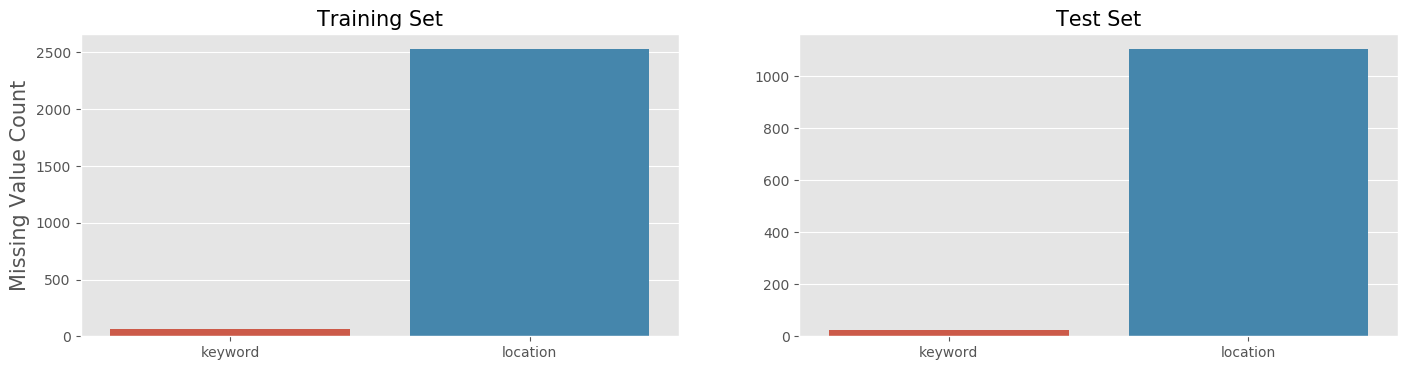

In [84]:
cols = ['keyword', 'location']
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[cols].isnull().sum().index, 
            y=train_df[cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[cols].isnull().sum().index, 
            y=test_df[cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count',size=15)
axes[0].set_title('Training Set', fontsize=15)
axes[1].set_title('Test Set', fontsize=15)

## 1-2) Target Distribution and Cardinality

Text(0, 0.5, 'Tweets')

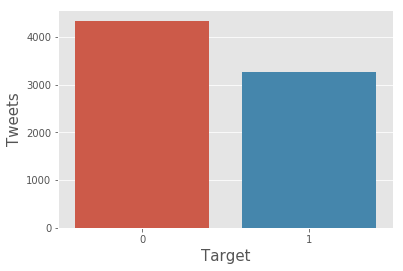

In [85]:
x = train_df.target.value_counts()
target_distribution = sns.barplot(x.index, x)
target_distribution.set_xlabel('Target', size=15)
target_distribution.set_ylabel('Tweets', size=15)

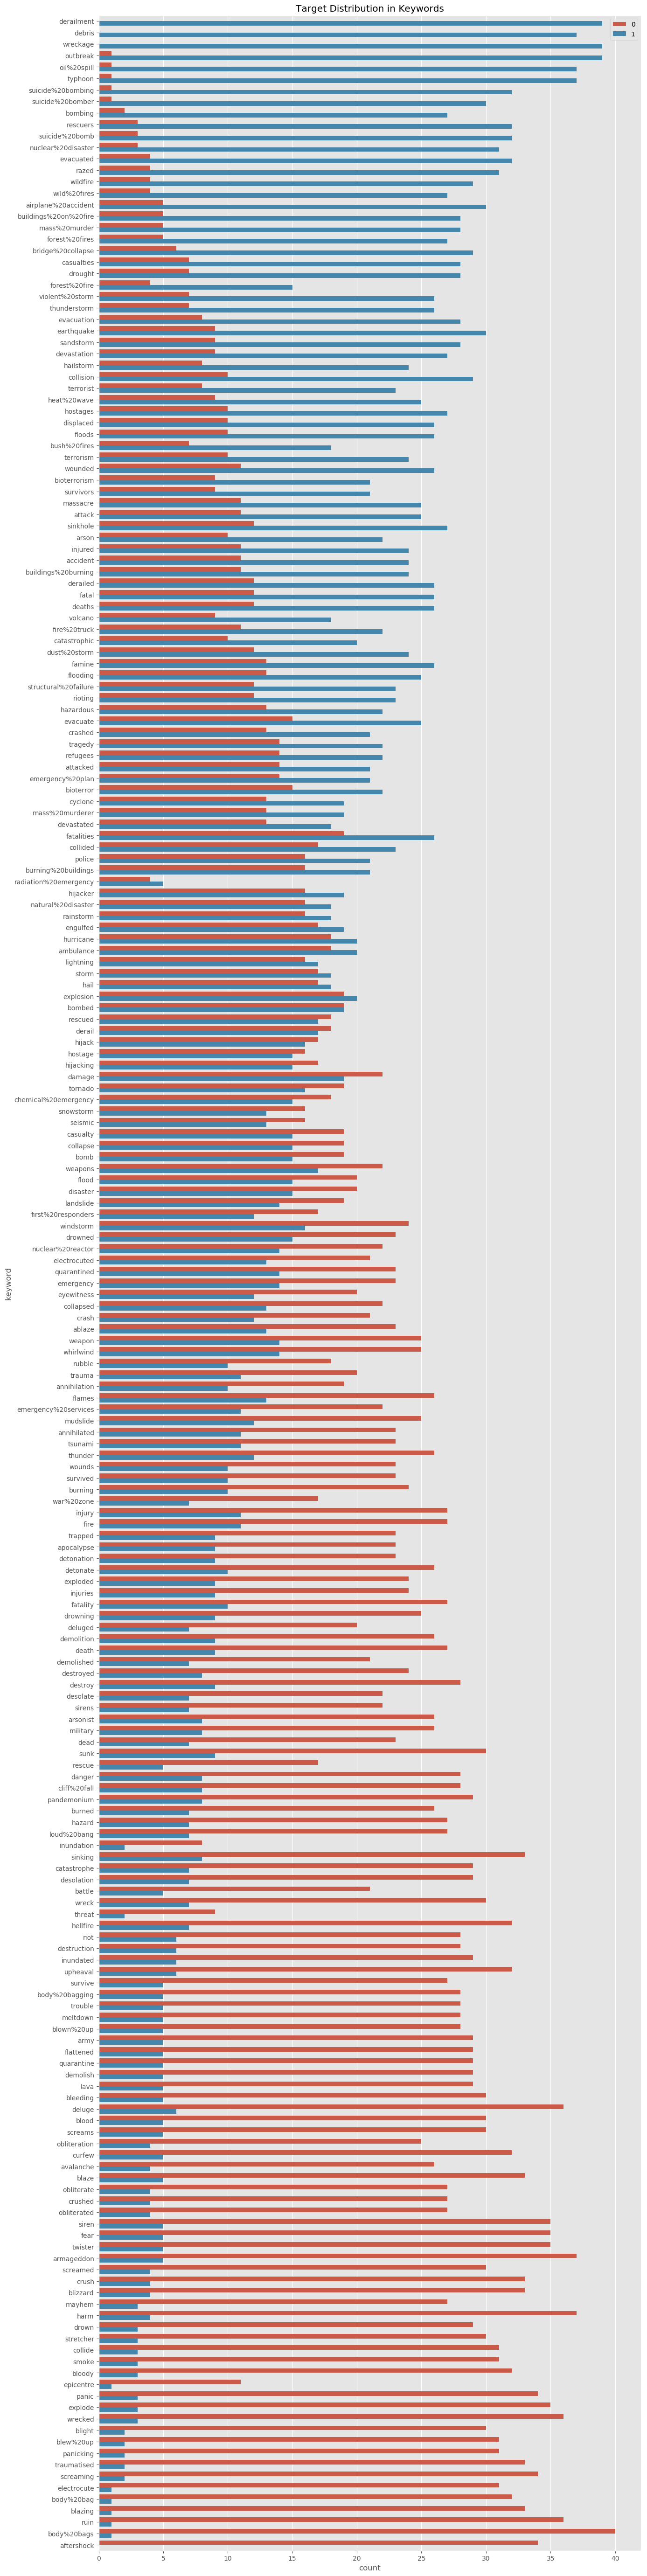

In [86]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(15, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=True)['target'])

#plt.tick_params(axis='x',labelsize=15)
#plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

## 1-3 ) Exploratory Data Analysis of Tweets

In [87]:
# number of characters
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# number of words
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# average word length of each tweet
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# number of stop words
stop_words = set(stopwords.words('english')) 
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# number of hashtag
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# number of mention
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

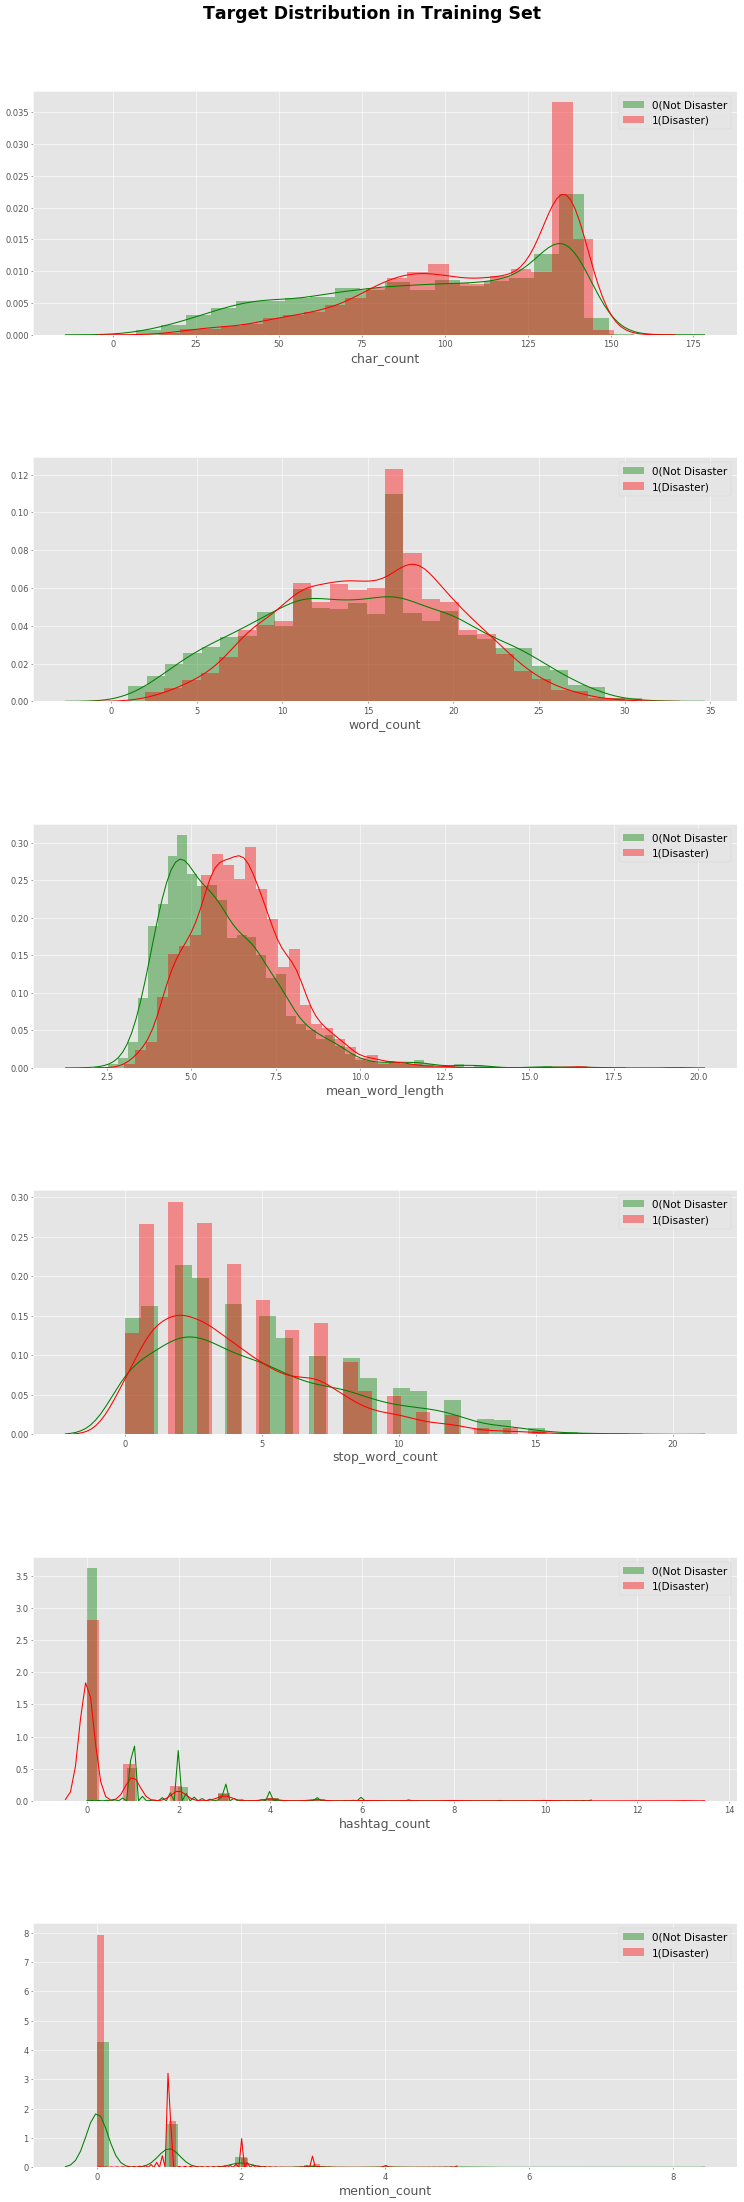

In [88]:
METAFEATURES = ['char_count', 'word_count', 'mean_word_length'
                , 'stop_word_count','hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1


fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(15, 50), dpi=50)


for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='0(Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='1(Disaster)', ax=axes[i], color='red')
    axes[i].legend(bbox_to_anchor=(0, 3))
    
    axes[i].set_xlabel(feature,fontsize=18)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend(fontsize=15)
    
fig.suptitle('Target Distribution in Training Set',fontsize=25, fontweight='bold')   
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(hspace = 0.5)
plt.show()

We can see that disaster tweets has  

1) more characters,  
2) longer average word length,  
3) less stop words  
4) and less mentions(@).

## 1-4) WordCloud

In [89]:
# disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
disaster_vec = cv.fit_transform(train_df.loc[DISASTER_TWEETS]['text'])
words = cv.get_feature_names()

count_mat = disaster_vec.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
count.shape
dis_word_count = list(zip(words,count))

dis_word_count = sorted(dis_word_count, key=lambda x:x[1],reverse=True)
dis_word_count[:10]

[('http', 2382),
 ('û_', 172),
 ('news', 140),
 ('amp', 135),
 ('https', 134),
 ('disaster', 121),
 ('california', 115),
 ('suicide', 112),
 ('police', 109),
 ('people', 105)]

In [90]:
# non-disastaer vector

cv = feature_extraction.text.CountVectorizer(stop_words='english')
non_dis_vec = cv.fit_transform(train_df.loc[~DISASTER_TWEETS]['text'])

words = cv.get_feature_names()
non_dis_count_mat = non_dis_vec.sum(axis=0)

non_dis_count = np.squeeze(np.asarray(non_dis_count_mat))

non_dis_word_count = list(zip(words,non_dis_count))  # transform to tuple (word,count)
non_dis_word_count = sorted(non_dis_word_count, key=lambda x:x[1],reverse=True)
non_dis_word_count[:10]

[('http', 1927),
 ('https', 277),
 ('like', 254),
 ('just', 234),
 ('amp', 209),
 ('û_', 176),
 ('new', 170),
 ('don', 138),
 ('body', 116),
 ('video', 96)]

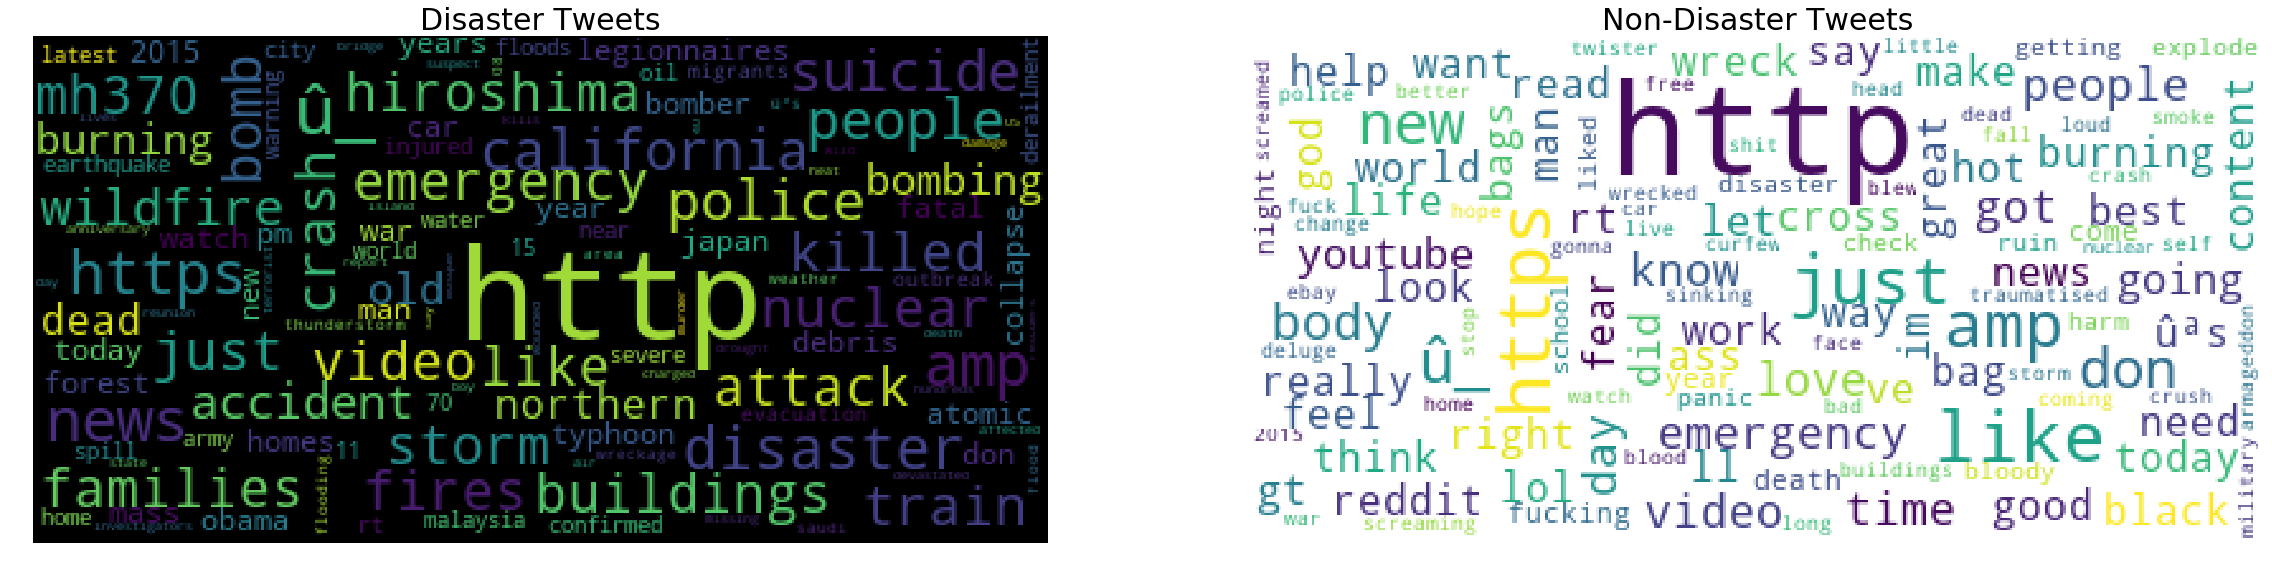

In [91]:
plt.figure(figsize=(40, 40))

plt.subplot(1,2,1).set_title("Disaster Tweets",fontsize=30)
dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='Black')
dis_cloud = dis_wc.generate_from_frequencies(dict(dis_word_count))
plt.imshow(dis_cloud)
plt.axis('off')

plt.subplot(1,2,2).set_title("Non-Disaster Tweets",fontsize=30)
non_dis_wc = WordCloud(max_font_size=50, max_words=120,background_color='White')
non_dis_cloud = non_dis_wc.generate_from_frequencies(dict(non_dis_word_count))
plt.imshow(non_dis_cloud)
plt.axis('off')

plt.show()

Texts need to be cleaned since there are useless words like 'http', 'https', or 'û_'.  
However we can see disaster tweets have more disaster related words like 'fires', 'killed', 'hiroshima' or 'nuclear'.

## 2) Preprocessing

## 2-1) Cleaning

Before modeling, we should clean text in both train and test data by removing stop words, punctuations, urls, emojis since they don't give much information about target.

In [92]:
concat_df = pd.concat([train_df,test_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [93]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')  # regular expression operations
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table) 

#remove words less than 3 
def remove_less_than(text):
    return ' '.join([i for i in text.split() if len(i) > 2])

Got these contractions from :  

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [94]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

In [95]:
!pip install pyspellchecke

In [96]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

ModuleNotFoundError: No module named 'spellchecker'

In [97]:
cleaned_train_df = train_df
# Not conveying value itself or referencing it
# Just naming it

cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_URL(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_html(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_emoji(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_punct(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in stop_words]))
cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : remove_less_than(x))
cleaned_train_df['text']=cleaned_train_df['text'].apply(expand_contractions)
#cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : correct_spellings(x))

cleaned_test_df = test_df
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_URL(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_html(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_emoji(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_punct(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x: ' '.join([w for w in str(x).lower().split() if w not in stop_words]))
cleaned_test_df['text']=cleaned_test_df['text'].apply(lambda x : remove_less_than(x))
cleaned_test_df['text']=cleaned_test_df['text'].apply(expand_contractions)
#cleaned_train_df['text']=cleaned_train_df['text'].apply(lambda x : correct_spellings(x))

(I tried to predict with the text after correcting the spelling, the leaderboard score decreased from 0.57523 to 0.55072.  
The result may differ depending on the model, but correcting spellings take too much time so I decided not to use it.)

In [98]:
test_df["text"].values[0:10]

array(['happened terrible car crash',
       'heard earthquake different cities stay safe everyone',
       'forest fire spot pond geese fleeing across street cannot save',
       'apocalypse lighting spokane wildfires',
       'typhoon soudelor kills china taiwan', 'shakingits earthquake',
       'theyd probably still show life arsenal yesterday', 'hey',
       'nice hat', 'fuck'], dtype=object)

In [99]:
cleaned_train_df[cleaned_train_df["target"] == 1]["text"].values[0:20]

array(['deeds reason earthquake may allah forgive',
       'forest fire near ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       '13000 people receive wildfires evacuation orders california',
       'got sent photo ruby alaska smoke wildfires pours school',
       'rockyfire update california hwy closed directions due lake county fire cafire wildfires',
       'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
       'top hill see fire woods',
       'theres emergency evacuation happening building across street',
       'afraid tornado coming area', 'three people died heat wave far',
       'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding',
       'raining flooding florida tampabay tampa days ive lost count',
       'flood bago myanmar arrived bago',
       'damage school bus multi car crash breaking',
       'bbcmtd wholesale mark

In [100]:
cleaned_train_df[cleaned_train_df["target"] == 0]["text"].values[0:20]

array(['whats man', 'love fruits', 'summer lovely', 'car fast',
       'goooooooaaaaaal', 'ridiculous', 'london cool', 'love skiing',
       'wonderful day', 'looooool', 'wayi cant eat shit', 'nyc last week',
       'love girlfriend', 'cooool', 'like pasta', 'end',
       'always try bring heavy metal', 'crying set ablaze',
       'plus side look sky last night ablaze',
       'phdsquares mufc theyve built much hype around new acquisitions doubt set epl ablaze season'],
      dtype=object)

## 2-2) Tokenizing

**방법1)**

In [101]:
def create_corpus(cleaned_train_df):
    corpus=[]
    for tweet in tqdm(cleaned_train_df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop_words))]
        corpus.append(words)
    return corpus

corpus=create_corpus(cleaned_train_df)
corpus

100%|██████████| 7613/7613 [00:01<00:00, 5175.12it/s]


[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive'],
 ['forest', 'fire', 'near', 'ronge', 'sask', 'canada'],
 ['residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['top', 'hill', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['afraid', 'tornado', 'coming', 'area'],
 ['three', 'people', 'died', 'heat', 'wave', 'far'],
 ['haha',
  'south',
  'tamp

**방법 2)**

In [102]:
# 정제와 단어 토큰화
vocab = {} # 파이썬의 dictionary 자료형
sentences = []

for i in cleaned_train_df['text']:
    sentence = word_tokenize(i) # 단어 토큰화를 수행합니다.
    result = []

    for word in sentence: 
        word = word.lower() # 모든 단어를 소문자화하여 단어의 개수를 줄입니다.
        if word not in stop_words: # 단어 토큰화 된 결과에 대해서 불용어를 제거합니다.
            if len(word) > 2: # 단어 길이가 2이하인 경우에 대하여 추가로 단어를 제거합니다.
                result.append(word)
                if word not in vocab:
                    vocab[word] = 0 
                vocab[word] += 1
    sentences.append(result) 
print(sentences)

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive'], ['forest', 'fire', 'near', 'ronge', 'sask', 'canada'], ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected'], ['13000', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'], ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school'], ['rockyfire', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires'], ['flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'areas'], ['top', 'hill', 'see', 'fire', 'woods'], ['theres', 'emergency', 'evacuation', 'happening', 'building', 'across', 'street'], ['afraid', 'tornado', 'coming', 'area'], ['three', 'people', 'died', 'heat', 'wave', 'far'], ['haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gon', 'gon', 'fvck',

## 3) Modeling

## 3-1) CountVectorize

In [103]:
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')

train_vectors = count_vectorizer.fit_transform(train_df["text"])

# 학습데이터에서 설정된 변환을 위한 기반 설정을 그대로 테스트 데이터에 적용
# 학습할 때와 동일한 기반설정으로 동일하게 테스트 데이터를 변환
test_vectors = count_vectorizer.transform(test_df["text"])

In [104]:
# text : 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
train_vectors[0]

<1x17160 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

## 3-2) Recurrent Neural Network

In [105]:
X_data = cleaned_train_df['text']
y_data = cleaned_train_df['target']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장


X_test_data = cleaned_test_df['text']

tokenizer.fit_on_texts(X_test_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences_test_data = tokenizer.texts_to_sequences(X_test_data)

In [106]:
print(sequences[:5])

[[4167, 679, 140, 48, 1383, 4168], [90, 3, 122, 6337, 6338, 1179], [1498, 1384, 1866, 522, 6339, 1499, 141, 1866, 522, 1180, 905], [2566, 7, 4169, 1181, 141, 1180, 21], [24, 1011, 212, 6340, 1867, 152, 1181, 6341, 87]]


In [107]:
word_to_index = tokenizer.word_index
print(word_to_index) # 각 단어의 빈도수가 높은 순서.

{'like': 1, 'amp': 2, 'fire': 3, 'get': 4, 'new': 5, 'via': 6, 'news': 7, 'people': 8, 'one': 9, 'dont': 10, 'emergency': 11, 'video': 12, 'disaster': 13, 'would': 14, 'police': 15, 'still': 16, 'suicide': 17, 'body': 18, 'crash': 19, 'burning': 20, 'first': 21, 'storm': 22, 'attack': 23, 'time': 24, 'got': 25, 'back': 26, 'know': 27, 'california': 28, 'fires': 29, 'buildings': 30, 'see': 31, 'going': 32, 'man': 33, 'day': 34, 'love': 35, 'two': 36, 'world': 37, 'cant': 38, 'bomb': 39, 'nuclear': 40, 'full': 41, 'hiroshima': 42, 'dead': 43, 'youtube': 44, 'watch': 45, 'today': 46, 'life': 47, 'think': 48, 'car': 49, 'train': 50, 'last': 51, 'killed': 52, 'accident': 53, 'good': 54, 'say': 55, 'make': 56, 'war': 57, 'could': 58, 'may': 59, 'many': 60, 'years': 61, 'families': 62, 'need': 63, 'even': 64, 'want': 65, 'way': 66, 'best': 67, 'right': 68, 'collapse': 69, 'bombing': 70, 'forest': 71, 'army': 72, 'mass': 73, 'home': 74, 'work': 75, 'take': 76, 'year': 77, 'really': 78, 'death'

In [108]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 14155
단어 집합(vocabulary)에서 희귀 단어의 비율: 63.76126126126126
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.469716330181445


In [109]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22201


메일의 최대 길이 : 21
메일의 평균 길이 : 8.964009


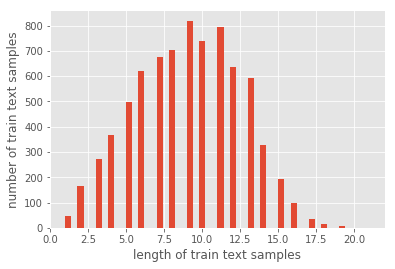

In [110]:
X_data = sequences # 단어를 정수 인코딩한 결과
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of train text samples')
plt.ylabel('number of train text samples')
plt.show()

In [111]:
max_len =max(len(l) for l in X_data)
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (7613, 21)


Let's create a model using RNN.

In [112]:
X_train = data
y_train = np.array(y_data)

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          710432    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 712,545
Trainable params: 712,545
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 5s 863us/sample - loss: 0.5712 - acc: 0.7023 - val_loss: 0.4907 - val_acc: 0.7735
Epoch 2/5
6090/6090 [==============================] - 4s 668us/sample - loss: 0.3663 - acc: 0.8511 - val_loss: 0.4864 - val_acc: 0.7630
Epoch 3/5
6090/6090 [==============================] - 4s 638us/sample - loss: 0.2698 - acc: 0.8987 - val_loss: 0.5214 - val_acc: 0.7472
Epoch 4/5
6090/6090 [==============================] - 4s 642us/sample - loss: 0.1887 - acc: 0.9392 - val_loss: 0.6270 - val_acc: 0.7387
Epoch 5/5
6090/6090 [==============================] - 4s 666us/sample - loss: 0.1440 - acc: 0.9571 - val_loss: 0.6917 - val_acc: 0.6802


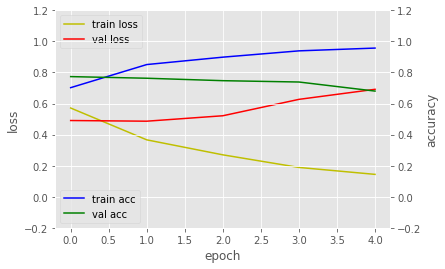

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

#### submission 1 :
* epochs = 2,  
* batch_size = 32,  
* validation_split=0.2  

#### score = 0.59975

#### submission 2 :

#### submission 3 :

## 3-3) Multi Layer Perceptron(MLP) Artificial Neural Network 

In [ ]:
MLPmodel = Sequential()
MLPmodel.add(Embedding(vocab_size, 128, input_length=max_len))
MLPmodel.add(Flatten())
MLPmodel.add(Dense(256, activation='relu'))
MLPmodel.add(Dense(1, activation='sigmoid'))

MLPmodel.summary()

In [ ]:
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=4, batch_size=16, validation_split=0.2)

MLPmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = MLPmodel.fit(X_train, y_train, epochs=4, batch_size=32, validation_split=0.2)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 3-4) Convolution Neural Network

## 3-5) Recurrent Convolution Neural Network(RCNN)

## 4) Make submission

In [ ]:
X_test_data =sequences_test_data # 단어를 정수 인코딩한 결과
print('test 메일의 최대 길이 : %d' % max(len(l) for l in X_test_data))
#max_len = max(len(l) for l in X_test_data)

test_pad = pad_sequences(X_test_data, maxlen = max_len)

In [ ]:
# practice
#sequences_test_data.shape()
print(test_pad.shape)

In [ ]:
sample_sub_2=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
y_pre=model.predict(test_pad)
y_pre=np.round(y_pre).astype(int).reshape(test_df.shape[0])
sub=pd.DataFrame({'id':sample_sub_2['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission_7.csv',index=False)

In [ ]:
sub.tail()

Let's start from assuming that count-vector and target value(0 or 1) have linear connection. For testing on the trining data, I'll use cross-validation and the metric will be F1 score, which this competition is asking for.

In [ ]:
ln_clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(ln_clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

+) TFIDF, LSA, LSTM, RNNs, ngram ,...

In [ ]:
ln_clf.fit(train_vectors, train_df['target'])

In [ ]:
count_vectorizer2 = feature_extraction.text.CountVectorizer(stop_words = 'english')
count_vectorizer2.fit_transform(train_df['text'])
test_vectors = count_vectorizer.transform(test_df["text"])

In [ ]:
#count_vectorizer2.vocabulary_

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_tfidf_vec = TfidfVectorizer().fit_transform(train_df['text'])
test_tfidf_vec = TfidfVectorizer().fit(test_df['text'])

In [ ]:
train_tfidf_vec

## submission example

In [ ]:
#mysample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [ ]:
mysample_submission["target"] = ln_clf.predict(test_vectors)

mysample_submission.head()

In [ ]:
mysample_submission.to_csv("mysubmission.csv", index=False)